In [1]:
from pymongo import MongoClient
import pandas as pd
import os

from dotenv import load_dotenv
import numpy as np
import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster


In [ ]:
import src.GeomapFunctions as gm
import src.mongodbFunctions as mdb

#### Loading tokens

In [2]:
load_dotenv()
client_id= os.getenv("client_id")
client_secret= os.getenv("client_secret")

NameError: name 'load_dotenv' is not defined

### Configuration info:
 - url_query : url that we will use for calling foursquare API
 - list of parameters that we will use on the differents searches and that we will consider for calculating the distances.
      - 2 different lists, once per langauge

     

In [3]:
url_query = 'https://api.foursquare.com/v2/venues/explore'

# TODO make this values taken by the input user interface in a dinamically way (different number of parameters)
list_sp = ["vegan", "Startup", "guarderia", "colegio", "discoteca", "starbucks", "trenes", "canina"]
list_en = ["vegan", "Startup", "nursery school", "school", "pubs", "starbucks", "train", "dog grummer"]


##### The user will be asked for a database name:
- If we introuce a new one, the program will create it
- If we don't introduce anything, the program we will load the default data base

In [4]:
db = gm.input_data_base()

Database Name: julian2
Creating database.... julian2
Database created
julian2


##### The user will be asked to introduce 3 cities ( the user could set any location):
- We will look for the coordinates of these cities.
- We will keep the cities names
- If the user doesn't introuduce anything or we provoke an error, the default city will be loaded
- This will happen for the 3 cities


In [5]:
city_name1, city_location1, city_name2, city_location2, city_name3, city_location3,city_lang1 ,city_lang2 ,city_lang3 = gm.input_cities(list_sp, list_en)


Set the first city: sidney
select a language for the first city: (en/sp): en
Set the second city: camberra
select a language for the first city: (en/sp): en
Set the third city: madrid
select a language for the first city: (en/sp): sp


#### This is and important step so lets explain it:

- First of all we delete all collections in our database, so we will start with a clean and empty data base


- Then we create structures for the 3 differents cities, which means:
    - We call the foursquare API and we create a json with the ino of all the search parameters for every city (**dic_json_api_response_for_city**) 
    - We reduce the json taking only the parameters we need and creating correctly the locaction attribute we will need for the GEOQUERIES. In summary we prepare the json to laad it in mongo (**build_dic_json_to_mongo**)
    - We create the collecions on MongoDB, we create json files (just in case we need it in the future) and we create the geo indexes (**create_collections_in_mongo**)
    

In [6]:
gm.drop_collections(db)
gm.create_structure(db, city_location1, city_name1, city_lang1, url_query, client_id, client_secret )
gm.create_structure(db, city_location2, city_name2, city_lang2, url_query, client_id, client_secret )
gm.create_structure(db, city_location3, city_name3, city_lang3, url_query, client_id, client_secret ) 


TypeError: documents must be a non-empty list

#### In this section we will be creating a Data Frame of distances between our cities and every parameter on the search list.
- We will be creating an aggration query **create_query_distances**
- This query will be call for every of the parameters in each city crearing a list of jsons **create_dict_distances**
- Then with the info of all the distances between every parameter in a city we will create a list of json just taken the elemens with less distance to our base point (in this case the 3 firsts)
- Finally we will create DataFrames for every city with this info . We will use it in the map and for calculating our marks


In [19]:
df_city_name1 = pd.DataFrame(gm.create_list_city_distances(db, city_location1,city_name1))
df_city_name2 = pd.DataFrame(gm.create_list_city_distances(db, city_location2,city_name2))
df_city_name3 = pd.DataFrame(gm.create_list_city_distances(db, city_location3,city_name3))

#### In this cell we will add the value column which will give us the total value of every city:
- We will calculate the weights of every parameter in **calculate_marks_mean** function:
   - This fucntion will simulate polls where every worker on the company will give a weight to every parameter
   - Then we will do the mean of all theses weights, and we will have our total weights for every parameter
- We will add this info to a new column percentage
- Because we don't want big distances values adulterate our final value, we will take logarithm to the distances columns to minimize this circumstance. We will create a new column for that (log)
- Finally we will multiply the log column with the weights columns, and we will have our value column

In [20]:
df_city_name1 = gm.values_total_df(db, city_location1, city_name1, df_city_name1)
df_city_name2 = gm.values_total_df(db, city_location2, city_name2, df_city_name2)
df_city_name3 = gm.values_total_df(db, city_location3, city_name3, df_city_name3)

In [21]:
df_city_name1.head(2)

,origin,feature,name1,distance1,latitude1,longitude1,name2,distance2,latitude2,longitude2,name3,distance3,latitude3,longitude3,percentage,log,value
0,seville_cartuja,startup,Tecnoincubadora de Empresas Marie Curie,523.030450,37.407285,-6.006128,Pabellón de Italia. Centro de Empresas,544.425910,37.407277,-6.004930,Endesa - Pabellón de México,814.015293,37.409122,-6.003013,0.113281,6.259640,0.709100
1,seville_cartuja,doggrummer,Kekosas Animal´s,1709.197396,37.392649,-5.994534,Estética y Peluquería Canina Woff-dog,4789.138714,37.369195,-5.978871,Regly Peluqueria Canina Y Felina,94388.256381,36.629250,-6.366180,0.129208,7.443779,0.961796


#### Now we will just doing a sum() of our value column which will give as the final mark to compare the different cities, the minimum mark will be the winner.

In [22]:
print(city_name1, df_city_name1["value"].sum())
print(city_name2, df_city_name2["value"].sum())
print(city_name3, df_city_name3["value"].sum())

seville_cartuja 7.180850517299804
brussels_diegem 6.840981725238648
reading_greenpark 7.751202440698902


#### In this last cell we will create a Map in folium adding markers for the different parameters in each city.

In [25]:
map_cities = folium.Map(location=[city_location2[0],city_location2[1]], zoom_start=13)
gm.set_markers(map_cities, df_city_name1, city_location1)
gm.set_markers(map_cities, df_city_name2, city_location2) 
gm.set_markers(map_cities, df_city_name3, city_location3)

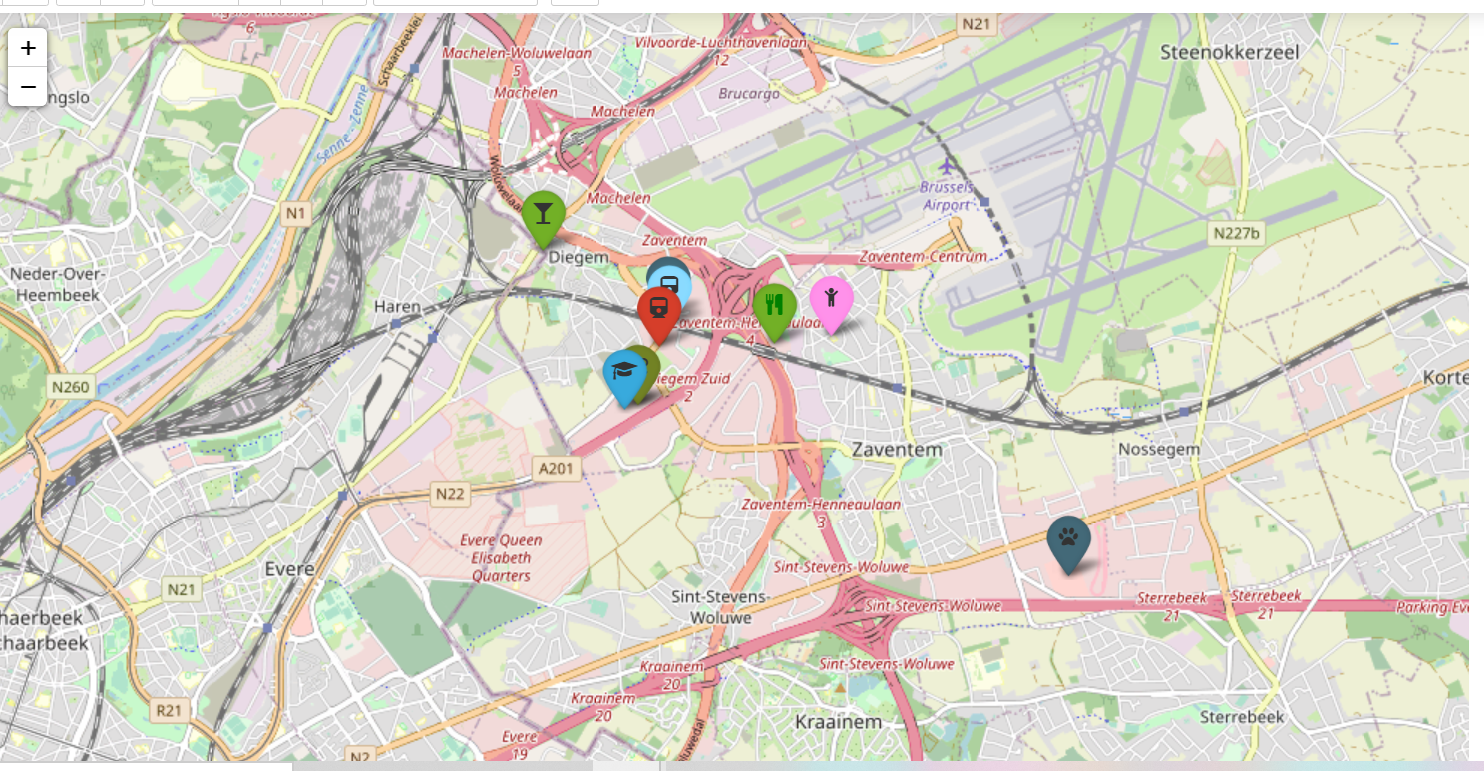